In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load the California housing dataset
housing = fetch_california_housing()
X, y = housing.data, housing.target
feature_names = housing.feature_names

print(f"Dataset shape: {X.shape}")
print(f"Features: {feature_names}")

Dataset shape: (20640, 8)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [3]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Scale the features for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Dictionary to store results
results = {}

# Function to evaluate models
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MSE: {mse:.4f}, R²: {r2:.4f}")
    return mse, r2

In [6]:
# Compare different models with all features
print("\n--- Models with all features ---")
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

for name, model in models.items():
    results[f"{name} (All Features)"] = evaluate_model(name, model, 
                                                      X_train_scaled, X_test_scaled, 
                                                      y_train, y_test)

# Apply RFE with different estimators
print("\n--- Models with RFE (4 features) ---")
n_features_to_select = 4

for name, model in models.items():
    if name != 'Lasso Regression':  # Lasso already performs feature selection
        rfe = RFE(estimator=model, n_features_to_select=n_features_to_select, step=1)
        X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
        X_test_rfe = rfe.transform(X_test_scaled)
        
        # Print selected features
        selected_indices = np.where(rfe.support_)[0]
        selected_features = [feature_names[i] for i in selected_indices]
        print(f"\n{name} selected features: {selected_features}")
        
        # Train model with selected features
        results[f"{name} (RFE)"] = evaluate_model(name, model, 
                                                 X_train_rfe, X_test_rfe, 
                                                 y_train, y_test)
        
        # Feature ranking
        print(f"Feature ranking: {rfe.ranking_}")


--- Models with all features ---
Linear Regression - MSE: 0.5559, R²: 0.5758
Ridge Regression - MSE: 0.5559, R²: 0.5758
Lasso Regression - MSE: 0.6796, R²: 0.4814
Random Forest - MSE: 0.2552, R²: 0.8053

--- Models with RFE (4 features) ---

Linear Regression selected features: ['MedInc', 'AveBedrms', 'Latitude', 'Longitude']
Linear Regression - MSE: 0.5627, R²: 0.5706
Feature ranking: [1 3 2 1 5 4 1 1]

Ridge Regression selected features: ['MedInc', 'AveBedrms', 'Latitude', 'Longitude']
Ridge Regression - MSE: 0.5627, R²: 0.5706
Feature ranking: [1 3 2 1 5 4 1 1]

Random Forest selected features: ['MedInc', 'AveOccup', 'Latitude', 'Longitude']
Random Forest - MSE: 0.2571, R²: 0.8038
Feature ranking: [1 2 3 5 4 1 1 1]


In [7]:
# For Lasso, examine coefficients to see automatic feature selection
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
lasso_coefs = pd.Series(lasso.coef_, index=feature_names)
print("\nLasso coefficients:")
print(lasso_coefs)

selected_by_lasso = lasso_coefs[lasso_coefs != 0].index.tolist()
print(f"Features selected by Lasso: {selected_by_lasso}")


Lasso coefficients:
MedInc        0.710598
HouseAge      0.106453
AveRooms     -0.000000
AveBedrms     0.000000
Population   -0.000000
AveOccup     -0.000000
Latitude     -0.011469
Longitude    -0.000000
dtype: float64
Features selected by Lasso: ['MedInc', 'HouseAge', 'Latitude']


In [8]:
# Visualize results
models_names = list(results.keys())
mse_values = [result[0] for result in results.values()]
r2_values = [result[1] for result in results.values()]

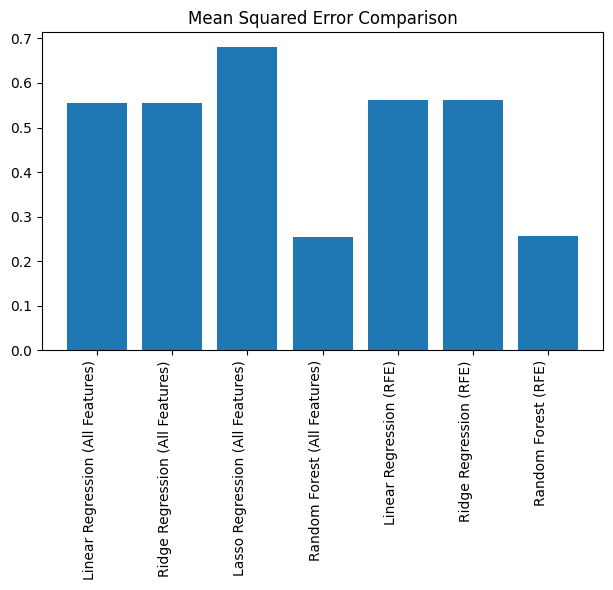

In [13]:
# Plot MSE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(models_names, mse_values)
plt.title('Mean Squared Error Comparison')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

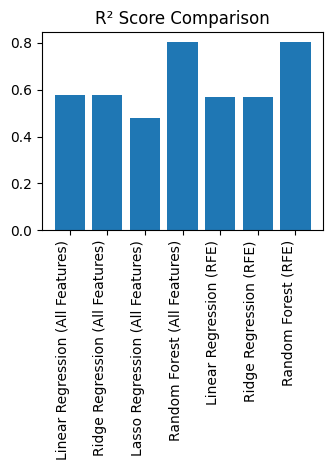

In [12]:
# Plot R²
plt.subplot(1, 2, 2)
plt.bar(models_names, r2_values)
plt.title('R² Score Comparison')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

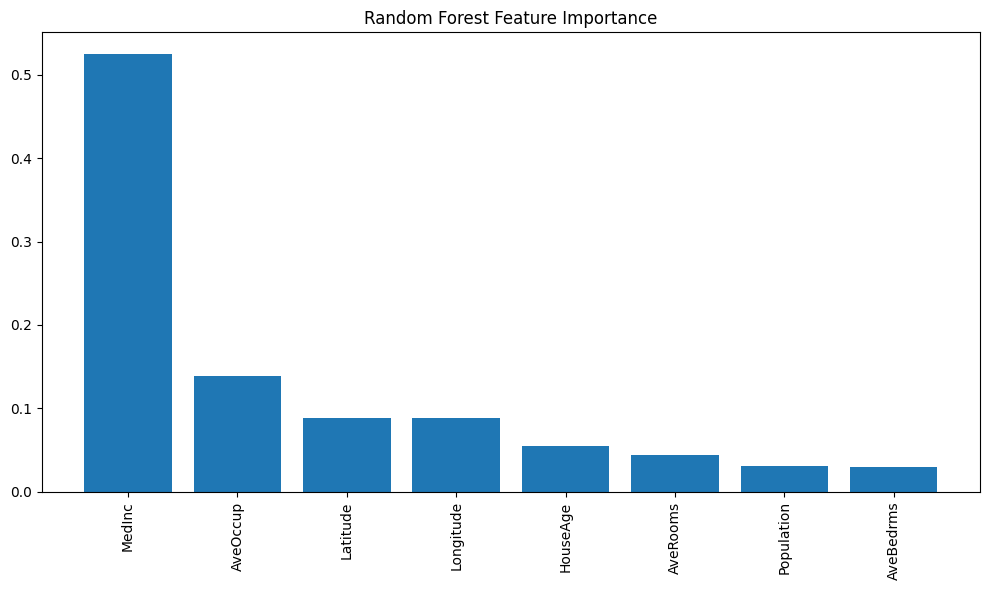

In [14]:
# Visualize feature importance from Random Forest (as a reference)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

plt.figure(figsize=(10, 6))
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.title('Random Forest Feature Importance')
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()